In [27]:
import gymnasium as gym
from typing import Tuple, Dict, Optional, Iterable, Callable
import matplotlib.pyplot as plt
import numpy as np
from IPython import display
import matplotlib
from matplotlib import animation
from typing import Tuple, Dict, Optional, Iterable

import numpy as np
import matplotlib
from matplotlib import animation

from IPython.display import HTML

import gym
from gym import spaces
from gym.error import DependencyNotInstalled

import pygame
from pygame import gfxdraw
from collections import defaultdict


In [16]:
env=gym.make('FrozenLake-v1', desc=None, map_name="4x4")


In [17]:
def display_video(frames):
    # Copied from: https://colab.research.google.com/github/deepmind/dm_control/blob/master/tutorial.ipynb
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    matplotlib.use(orig_backend)
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
        im.set_data(frame)
        return [im]
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                    interval=50, blit=True, repeat=False)
    return HTML(anim.to_html5_video())

In [18]:
def test_agent(environment, policy, episodes=10):
    frames = []
    for episode in range(episodes):
        state = env.reset()
        done = False
        frames.append(env.render(mode="rgb_array"))

        while not done:
            p = policy(state)
            if isinstance(p, np.ndarray):
                action = np.random.choice(4, p=p)
            else:
                action = p
            next_state, reward, done, extra_info = env.step(action)
            img = env.render(mode="rgb_array")
            frames.append(img)
            state = next_state

    return display_video(frames)

In [19]:
env.reset()

0

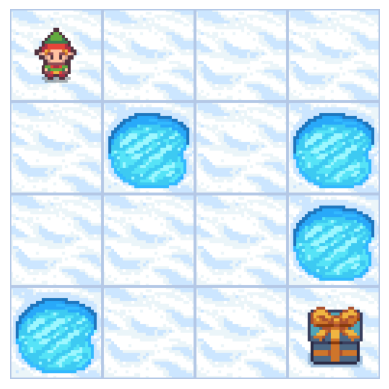

In [20]:
frame=env.render(mode='rgb_array')
plt.axis('off')
plt.imshow(frame)

In [21]:
print(f"Observation space shape: {env.observation_space}")
print(f"Number of actions: {env.action_space.n}")

Observation space shape: Discrete(16)
Number of actions: 4


In [32]:
qsa= defaultdict(lambda:np.zeros(env.action_space.n))

In [33]:
def policy_pi_s(state , epsilon=0.):
    if np.random.random() < epsilon:
        return np.random.randint(4)
    else:
        av=qsa[state]
        return np.random.choice(np.flatnonzero(av==av.max()))

In [40]:
def on_policy_mc_control(policy,action_values,episodes,gamma=0.99,epsilon=0.2):
    sa_returns={}

    for episode in range(1, episodes+1):
        state=env.reset()
        done=False
        transitions=[]

        while not done:
            action=policy(state,epsilon)
            next_state,reward,done,info=env.step(action)
            transitions.append([state,action,reward])
            state=next_state
        G=0
        for state_t,action_t,reward_t in reversed(transitions):
            G=reward_t+gamma*G

            if not (state_t,action_t) in sa_returns:
                sa_returns[(state_t,action_t)]=[]
            sa_returns[(state_t,action_t)].append(G)
            action_values[state_t][action_t]=np.mean(sa_returns[(state_t,action_t)])

In [41]:
on_policy_mc_control(policy_pi_s, qsa , episodes=10000 )

In [42]:
test_agent(env,policy_pi_s)